In [288]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor, BernoulliRBM
warnings.filterwarnings("ignore")

In [289]:
seinfeld = pd.read_csv('seinfeld episode rankings.csv')

In [290]:
seinfeld

,Title,Plot,Quotability/cultural impact,Laughs,Total score,IMDb rating,IMDb rank,Notes,Season,episode
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [291]:
seinfeld.columns=['title','plot','quotability','laughs','total_score','imdb_rating','imdb_rank','notes','season','episode']

In [292]:
#seinfeld=seinfeld[seinfeld.season<7]

In [293]:
seinfeld.sort_values('total_score',ascending=False)

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
77,the_marine_biologist,5.0,9.0,52.0,101.739130,9.2,5.0,NaN,5.0,14.0
83,the_hamptons,5.0,9.0,48.0,93.913043,8.9,10.0,"""Shrinkage""",5.0,20.0
50,the_contest,5.0,10.0,31.0,67.391304,9.6,1.0,first appearance of Estelle.,4.0,11.0
74,the_conversion,5.0,9.0,30.0,58.695652,8.1,112.0,NaN,5.0,11.0
84,the_opposite,4.0,9.0,31.5,49.304348,9.6,1.0,NaN,5.0,21.0
...,...,...,...,...,...,...,...,...,...,...
102,the_doodle,NaN,NaN,NaN,0.000000,8.2,98.0,NaN,6.0,18.0
103,the_fusilli_jerry,NaN,NaN,NaN,0.000000,8.7,24.0,NaN,6.0,19.0
104,the_diplomat's_club,NaN,NaN,NaN,0.000000,8.1,112.0,NaN,6.0,20.0
105,the_face_painter,NaN,NaN,NaN,0.000000,8.4,58.0,NaN,6.0,21.0


In [294]:
scripts = pd.read_csv('seinfeld_data/scripts.csv')

In [295]:
episodes = pd.read_csv('seinfeld_data/episode_info.csv')

In [296]:
episodes = episodes.drop(columns='Unnamed: 0')

In [297]:
episodes.Title = episodes.Title.astype(str)

In [298]:
episodes.Title = episodes.Title.str.lower().str.replace(' ','_').str.replace(',','')

In [299]:
scripts = scripts.drop(columns='Unnamed: 0')

In [300]:
scripts[0:211].SEID = 'S01E00'
scripts[0:211].EpisodeNo = 0.0

In [301]:
scripts['line']=scripts.Character.str.strip() +': ' + scripts.Dialogue.str.strip()

,Season,EpisodeNo,Title,AirDate,Writers,Director,SEID
0,1.0,1.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E01
1,1.0,1.0,the_stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01
2,1.0,2.0,the_robbery,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02
3,1.0,3.0,male_unbonding,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03
4,1.0,4.0,the_stock_tip,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04
...,...,...,...,...,...,...,...
169,9.0,17.0,the_bookstore,"April 9, 1998",Spike Feresten,Andy Ackerman,S09E17
170,9.0,18.0,the_frogger,"April 23, 1998","Gregg Kavet, Andy Robin",Andy Ackerman,S09E18
171,9.0,19.0,the_maid,"April 30, 1998","Alec Berg, David Mandel, Jeff Schaffer",Andy Ackerman,S09E19
172,9.0,20.0,the_puerto_rican_day,"May 7, 1998","Alec Berg, Jennifer Crittenden, Spike Feresten...",Andy Ackerman,S09E20


In [302]:
episodes.SEID[0] = 'S01E00'
episodes.EpisodeNo[0] = 0.0

In [303]:
scripts

,Character,Dialogue,EpisodeNo,SEID,Season
0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0
2,GEORGE,Are you through?,0.0,S01E00,1.0
3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,S01E00,1.0
...,...,...,...,...,...
54611,JERRY,Grand theft auto - don't steal any of my jokes.,23.0,S09E23,9.0
54612,PRISONER 3,You suck - I'm gonna cut you.,23.0,S09E23,9.0
54613,JERRY,"Hey, I don't come down to where you work, and ...",23.0,S09E23,9.0
54614,GUARD,"Alright, Seinfeld, that's it. Let's go. Come on.",23.0,S09E23,9.0


In [304]:
scripts[scripts.SEID=='S01E00']

,Character,Dialogue,EpisodeNo,SEID,Season
0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0
2,GEORGE,Are you through?,0.0,S01E00,1.0
3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,S01E00,1.0
...,...,...,...,...,...
206,LAURA,"Yeah, yeah, hes a great guy...",0.0,S01E00,1.0
207,JERRY,Yeah.,0.0,S01E00,1.0
208,LAURA,"Youd really like him, you know, I cant wait to...",0.0,S01E00,1.0
209,JERRY,Me too!,0.0,S01E00,1.0


In [305]:
scripts.Character=scripts.Character.str.replace(r"\(.*\)","")

In [306]:
line_count=scripts.Character.value_counts().head(475)

In [307]:
scripts.Character.str.strip().value_counts().head(10)

JERRY       14905
GEORGE       9781
ELAINE       8073
KRAMER       6723
NEWMAN        649
MORTY         507
HELEN         474
FRANK         438
SUSAN         382
[Setting      293
Name: Character, dtype: int64

In [308]:
episodes["SEID"] = episodes.SEID.astype(str)
scripts["SEID"] = scripts.SEID.astype(str)

In [309]:
scripts[scripts.SEID=='S01E04']

,Character,Dialogue,EpisodeNo,SEID,Season
1078,JERRY,Went out to dinner the other night. Check came...,4.0,S01E04,1.0
1079,JERRY,I think Superman probably has a very good sens...,4.0,S01E04,1.0
1080,GEORGE,I never heard him say anything really funny.,4.0,S01E04,1.0
1081,JERRY,"But its common sense. Hes got super strength, ...",4.0,S01E04,1.0
1082,GEORGE,"You would think that, but either youre born wi...",4.0,S01E04,1.0
...,...,...,...,...,...
1303,JERRY,We went over that.,4.0,S01E04,1.0
1304,GEORGE,Pst. (moves in close with Elaine and Jerry) Wi...,4.0,S01E04,1.0
1305,JERRY,A robot butcher?,4.0,S01E04,1.0
1306,GEORGE,"Shhhhh. If you want to get in, theres very lit...",4.0,S01E04,1.0


In [310]:
pd.merge(episodes, right=scripts, on='SEID')

,Season_x,EpisodeNo_x,Title,AirDate,Writers,Director,SEID,Character,Dialogue,EpisodeNo_y,Season_y
0,1.0,0.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,JERRY,Do you know what this is all about? Do you kno...,0.0,1.0
1,1.0,0.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,1.0
2,1.0,0.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,GEORGE,Are you through?,0.0,1.0
3,1.0,0.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,JERRY,"You do of course try on, when you buy?",0.0,1.0
4,1.0,0.0,good_news_bad_news,"July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E00,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
54611,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,JERRY,Grand theft auto - don't steal any of my jokes.,23.0,9.0
54612,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,PRISONER 3,You suck - I'm gonna cut you.,23.0,9.0
54613,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,JERRY,"Hey, I don't come down to where you work, and ...",23.0,9.0
54614,9.0,23.0,the_finale,"May 14, 1998",Larry David,Andy Ackerman,S09E23,GUARD,"Alright, Seinfeld, that's it. Let's go. Come on.",23.0,9.0


In [311]:
seinfeld.title[0] = 'good_news_bad_news'

In [312]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
102,the_doodle,NaN,NaN,NaN,0.000000,8.2,98.0,NaN,6.0,18.0
103,the_fusilli_jerry,NaN,NaN,NaN,0.000000,8.7,24.0,NaN,6.0,19.0
104,the_diplomat's_club,NaN,NaN,NaN,0.000000,8.1,112.0,NaN,6.0,20.0
105,the_face_painter,NaN,NaN,NaN,0.000000,8.4,58.0,NaN,6.0,21.0


In [313]:
seinfeld

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
0,good_news_bad_news,4.0,7.0,7.0,8.521739,7.6,166.0,2nd button joke,1.0,1.0
1,male_unbonding,3.0,6.5,2.0,1.695652,7.3,173.0,Kramer's pizza idea,1.0,2.0
2,the_stakeout,4.0,7.0,9.0,10.956522,7.7,160.0,Art Vandelay first appearance,1.0,3.0
3,the_robbery,3.0,3.5,5.5,2.510870,7.6,166.0,NaN,1.0,4.0
4,the_stock_tip,3.0,3.0,6.5,2.543478,7.5,168.0,NaN,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
102,the_doodle,NaN,NaN,NaN,0.000000,8.2,98.0,NaN,6.0,18.0
103,the_fusilli_jerry,NaN,NaN,NaN,0.000000,8.7,24.0,NaN,6.0,19.0
104,the_diplomat's_club,NaN,NaN,NaN,0.000000,8.1,112.0,NaN,6.0,20.0
105,the_face_painter,NaN,NaN,NaN,0.000000,8.4,58.0,NaN,6.0,21.0


In [314]:
episodes.columns = episodes.columns.str.lower()


In [315]:
seinfeld.title = seinfeld.title.str.replace(r"\d:\d*","").str.strip().str.replace(' ','_').str.lower()

In [316]:
seinfeld[seinfeld.title=="the_cafe"]

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season,episode
23,the_cafe,4.0,6.0,9.5,9.913043,8.4,58.0,Babu’s first appearance,3.0,7.0


In [317]:
episodes[episodes.title=='the_cafe']

,season,episodeno,title,airdate,writers,director,seid
23,3.0,7.0,the_cafe,"November 6, 1991",Tom Leopold,Tom Cherones,S03E07


In [318]:
episodes.title.to_csv('titles.csv')

In [319]:
seinfeld=pd.merge(seinfeld, right = episodes, on='title')

In [320]:
seinfeld.sort_values('total_score',ascending=True).head(10)

,title,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,notes,season_x,episode,season_y,episodeno,airdate,writers,director,seid
106,the_understudy,NaN,NaN,NaN,0.0,7.9,149.0,NaN,6.0,22.0,6.0,24.0,"May 18, 1995","Marjorie Gross, Carol Leifer",Andy Ackerman,S06E24
93,the_secretary,NaN,NaN,3.0,0.0,8.1,112.0,NaN,6.0,9.0,6.0,9.0,"December 8, 1994","Carol Leifer, Marjorie Gross",David Owen Trainor,S06E09
94,the_race,NaN,NaN,NaN,0.0,8.9,10.0,NaN,6.0,10.0,6.0,10.0,"December 15, 1994","Tom Gammill, Max Pross and Larry David",Andy Ackerman,S06E10
95,the_switch,NaN,NaN,NaN,0.0,8.9,10.0,NaN,6.0,11.0,6.0,11.0,"January 5, 1995",Bruce Kirschbaum and Sam Kass,Andy Ackerman,S06E11
96,the_label_maker,NaN,NaN,NaN,0.0,8.5,49.0,NaN,6.0,12.0,6.0,12.0,"January 19, 1995","Alec Berg, Jeff Schaffer",Andy Ackerman,S06E12
97,the_scofflaw,NaN,NaN,NaN,0.0,8.0,135.0,NaN,6.0,13.0,6.0,13.0,"January 26, 1995",Peter Mehlman,Andy Ackerman,S06E13
98,the_beard,NaN,NaN,NaN,0.0,8.2,98.0,NaN,6.0,14.0,6.0,16.0,"February 9, 1995",Carol Leifer,Andy Ackerman,S06E16
99,the_kiss_hello,NaN,NaN,NaN,0.0,8.2,98.0,NaN,6.0,15.0,6.0,17.0,"February 16, 1995","Larry David, Jerry Seinfeld",Andy Ackerman,S06E17
100,the_doorman,NaN,NaN,NaN,0.0,8.2,98.0,NaN,6.0,16.0,6.0,18.0,"February 23, 1995","Tom Gammill, Max Pross",Andy Ackerman,S06E18
105,the_face_painter,NaN,NaN,NaN,0.0,8.4,58.0,NaN,6.0,21.0,6.0,23.0,"May 11, 1995",Larry David,Andy Ackerman,S06E23


In [321]:
seinfeld.director = seinfeld.director.replace('David&nbsp; Steinberg','David Steinberg')

In [322]:
seinfeld.director.value_counts()

Tom Cherones          80
Andy Ackerman         21
David Steinberg        2
Art Wolff              1
Joshua White           1
Jason Alexander        1
David Owen Trainor     1
Name: director, dtype: int64

In [323]:
scripts.Character = scripts.Character.str.strip()
scripts.Character = scripts.Character.replace(r'babu.*|BABU.*','BABU')

In [324]:
scripts.Character.nunique()

1214

In [325]:
scripts=scripts[~scripts.Character.str.contains(r'\(\*|[a-z]|http')]

In [326]:
#scripts = scripts.drop(index=scripts[(scripts.Character==r'http')|(scripts.Dialogue.isnull())].index.tolist())
grouped_scripts=scripts.groupby('SEID')

In [327]:
for key, item in grouped_scripts:
    print(grouped_scripts.get_group(key), "\n\n")

    Character                                           Dialogue  EpisodeNo  \
0       JERRY  Do you know what this is all about? Do you kno...        0.0   
1       JERRY  (pointing at Georges shirt) See, to me, that b...        0.0   
2      GEORGE                                   Are you through?        0.0   
3       JERRY             You do of course try on, when you buy?        0.0   
4      GEORGE  Yes, it was purple, I liked it, I dont actuall...        0.0   
..        ...                                                ...        ...   
206     LAURA                     Yeah, yeah, hes a great guy...        0.0   
207     JERRY                                              Yeah.        0.0   
208     LAURA  Youd really like him, you know, I cant wait to...        0.0   
209     JERRY                                            Me too!        0.0   
210     JERRY  I swear, I have absolutely no idea what women ...        0.0   

       SEID  Season  
0    S01E00     1.0  
1    S0

[350 rows x 5 columns] 


          Character                                           Dialogue  \
29856         JERRY  Look at you. Why don't you use a fork? You're ...   
29857        ELAINE                           I know. I need a lesson.   
29858         JERRY       You stink. You know you stink. What is this?   
29859        ELAINE                             Oh. My ballet tickets.   
29860         JERRY                           Oh. Your ballet tickets.   
...             ...                                                ...   
30148        KRAMER  Hey, how you doing Stu? Eddie, my man. You aga...   
30149           MAN  I've got an eyewitness to that jewelry store b...   
30150  HOMELESS MAN  That's the guy officer. The guy there in the m...   
30151           MAN     Hey you, you with the high hair, step forward.   
30152        KRAMER                                                Me?   

       EpisodeNo    SEID  Season  
29856       16.0  S06E16     6.0  
29857       16.

In [328]:
seinfeld.writers.value_counts()

Larry David                                               24
Larry Charles                                             15
Larry David, Jerry Seinfeld                               13
Peter Mehlman                                             10
Tom Gammill, Max Pross                                     7
Alec Berg, Jeff Schaffer                                   3
Larry David and Larry Levin                                2
Carol Leifer                                               2
Bruce Kirschbaum                                           2
Larry David, Larry Charles                                 2
Andy Robin                                                 2
Tom Leopold                                                2
Elaine Pope, Larry Charles                                 1
Peter Mehlman, Carol Leifer                                1
Marjorie Gross                                             1
Gregg Kavet, Andy Robin                                    1
Bruce Kirschbaum and Sam

In [329]:
scripts = scripts.drop(index=scripts[scripts.Character=='http'].index.tolist())

In [330]:
for Character, Dialogue in grouped_scripts:
    #print(f'{SEID}')
    print('--------')
    print(f'{Character}: {Dialogue}')

--------
S01E00:     Character                                           Dialogue  EpisodeNo  \
0       JERRY  Do you know what this is all about? Do you kno...        0.0   
1       JERRY  (pointing at Georges shirt) See, to me, that b...        0.0   
2      GEORGE                                   Are you through?        0.0   
3       JERRY             You do of course try on, when you buy?        0.0   
4      GEORGE  Yes, it was purple, I liked it, I dont actuall...        0.0   
..        ...                                                ...        ...   
206     LAURA                     Yeah, yeah, hes a great guy...        0.0   
207     JERRY                                              Yeah.        0.0   
208     LAURA  Youd really like him, you know, I cant wait to...        0.0   
209     JERRY                                            Me too!        0.0   
210     JERRY  I swear, I have absolutely no idea what women ...        0.0   

       SEID  Season  
0    S01E00 

[283 rows x 5 columns]
--------
S06E07:       Character                                           Dialogue  EpisodeNo  \
27555  WAITRESS  O.K. Cowboys, (taps pencil on her pad) What'll...        7.0   
27556     JERRY   Ill have the, ah, turkey club without the bacon.        7.0   
27557    GEORGE  And ah, Ill have the bacon club without the tu...        7.0   
27558  WAITRESS          George, don't make me get tough with you.        7.0   
27559    GEORGE                Why, you think you can, beat me up?        7.0   
...         ...                                                ...        ...   
27941     BANIA           (leans backwards from the counter) Yeah!        7.0   
27942    ELAINE  There it goes. (pointing at Simon walking out ...        7.0   
27943     BANIA  Hey! Hey! (he runs out the door after Simon; f...        7.0   
27944     SIMON  (from outside Monk's) What are you doing? Unha...        7.0   
27945     BANIA                 (from outside Monk's) Take It Off!   

In [331]:
import dask.dataframe as dd

In [332]:
scripts_dd=dd.from_pandas(scripts,npartitions=54615)

In [333]:
scripts_dd

,Character,Dialogue,EpisodeNo,SEID,Season
npartitions=53961,,,,,
0,object,object,float64,object,float64
1,...,...,...,...,...
...,...,...,...,...,...
54614,...,...,...,...,...
54615,...,...,...,...,...


In [334]:
seinfeld_prepped=seinfeld.drop(columns=['season_x','episode','notes','title','seid'])

In [335]:
#seinfeld_prepped.airdate=pd.to_datetime(seinfeld_prepped.airdate)
#seinfeld_prepped = seinfeld_prepped.set_index('airdate').sort_values(by='airdate')

In [336]:
seinfeld_prepped = pd.get_dummies(seinfeld_prepped, columns=['writers','director'], drop_first=True)

In [337]:
train=seinfeld_prepped[seinfeld_prepped.season_y<4]
validate=seinfeld_prepped[seinfeld_prepped.season_y>3]

In [338]:
train

,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,season_y,episodeno,airdate,"writers_Andy Cowan and Larry David, Jerry Seinfeld",...,"writers_Tom Gammill, Max Pross","writers_Tom Gammill, Max Pross and Larry David","writers_Tom Gammill, Max Pross and Larry David, Jerry Seinfeld",writers_Tom Leopold,director_Art Wolff,director_David Owen Trainor,director_David Steinberg,director_Jason Alexander,director_Joshua White,director_Tom Cherones
0,4.0,7.0,7.0,8.521739,7.6,166.0,1.0,0.0,"July 5, 1989",0,...,0,0,0,0,1,0,0,0,0,0
1,3.0,6.5,2.0,1.695652,7.3,173.0,1.0,3.0,"June 14, 1990",0,...,0,0,0,0,0,0,0,0,0,1
2,4.0,7.0,9.0,10.956522,7.7,160.0,1.0,1.0,"May 31, 1990",0,...,0,0,0,0,0,0,0,0,0,1
3,3.0,3.5,5.5,2.510870,7.6,166.0,1.0,2.0,"June 7, 1990",0,...,0,0,0,0,0,0,0,0,0,1
4,3.0,3.0,6.5,2.543478,7.5,168.0,1.0,4.0,"June 21, 1990",0,...,0,0,0,0,0,0,0,0,0,1
5,3.0,5.0,7.5,4.891304,7.7,160.0,2.0,1.0,"January 16, 1991",0,...,0,0,0,0,0,0,0,0,0,1
6,4.0,5.0,8.0,6.956522,7.9,149.0,2.0,2.0,"January 30, 1991",0,...,0,0,0,0,0,0,0,0,0,1
7,5.0,6.0,8.5,11.086957,8.3,79.0,2.0,3.0,"February 6, 1991",0,...,0,0,0,0,0,0,0,0,0,1
8,4.0,3.0,13.5,7.043478,8.4,58.0,2.0,4.0,"February 13, 1991",0,...,0,0,0,0,0,0,0,0,0,1
9,2.0,7.0,9.5,5.782609,7.9,149.0,2.0,5.0,"April 4, 1991",0,...,0,0,0,0,0,0,0,0,0,1


In [339]:
def get_script():
    for i in seinfeld.seid.to_list():
        for episode in scripts.SEID.to_list():
            script=f'TITLE: {i}\n'
            if str(scripts.SEID) == str(i):
                script += f'{scripts.Character}: {scripts.Dialogue}'
            else:
                continue
        return(script)

In [340]:
start = scripts.index[scripts.SEID=='S01E00'][0]
end = scripts.index[scripts.SEID=='S01E00'][-1] +1

In [341]:
train

,plot,quotability,laughs,total_score,imdb_rating,imdb_rank,season_y,episodeno,airdate,"writers_Andy Cowan and Larry David, Jerry Seinfeld",...,"writers_Tom Gammill, Max Pross","writers_Tom Gammill, Max Pross and Larry David","writers_Tom Gammill, Max Pross and Larry David, Jerry Seinfeld",writers_Tom Leopold,director_Art Wolff,director_David Owen Trainor,director_David Steinberg,director_Jason Alexander,director_Joshua White,director_Tom Cherones
0,4.0,7.0,7.0,8.521739,7.6,166.0,1.0,0.0,"July 5, 1989",0,...,0,0,0,0,1,0,0,0,0,0
1,3.0,6.5,2.0,1.695652,7.3,173.0,1.0,3.0,"June 14, 1990",0,...,0,0,0,0,0,0,0,0,0,1
2,4.0,7.0,9.0,10.956522,7.7,160.0,1.0,1.0,"May 31, 1990",0,...,0,0,0,0,0,0,0,0,0,1
3,3.0,3.5,5.5,2.510870,7.6,166.0,1.0,2.0,"June 7, 1990",0,...,0,0,0,0,0,0,0,0,0,1
4,3.0,3.0,6.5,2.543478,7.5,168.0,1.0,4.0,"June 21, 1990",0,...,0,0,0,0,0,0,0,0,0,1
5,3.0,5.0,7.5,4.891304,7.7,160.0,2.0,1.0,"January 16, 1991",0,...,0,0,0,0,0,0,0,0,0,1
6,4.0,5.0,8.0,6.956522,7.9,149.0,2.0,2.0,"January 30, 1991",0,...,0,0,0,0,0,0,0,0,0,1
7,5.0,6.0,8.5,11.086957,8.3,79.0,2.0,3.0,"February 6, 1991",0,...,0,0,0,0,0,0,0,0,0,1
8,4.0,3.0,13.5,7.043478,8.4,58.0,2.0,4.0,"February 13, 1991",0,...,0,0,0,0,0,0,0,0,0,1
9,2.0,7.0,9.5,5.782609,7.9,149.0,2.0,5.0,"April 4, 1991",0,...,0,0,0,0,0,0,0,0,0,1


In [342]:
x_train = train.drop(columns=['plot','quotability','laughs','total_score','airdate'])
y_train = train.total_score
x_validate = validate.drop(columns=['plot','quotability','laughs','total_score','airdate'])
y_validate = validate.total_score

In [343]:
regr = MLPRegressor( max_iter=1500).fit(x_train, y_train)

In [344]:
predictions=pd.DataFrame(regr.predict(x_validate),columns=['predict'])
regr.score(x_validate,y_validate)

-0.4836003242701825

In [345]:
y_validate=pd.concat([y_validate.reset_index(),predictions],axis=1)

<AxesSubplot:>

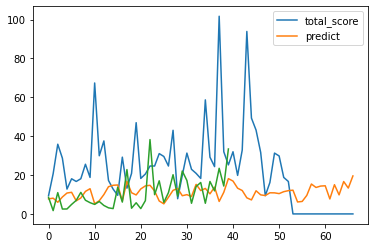

In [346]:
y_validate.drop(columns='index').plot()
y_train.plot()

<AxesSubplot:>

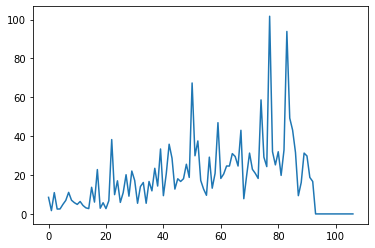

In [347]:
seinfeld.total_score.plot()

In [348]:
seinfeld_prepped.airdate = pd.to_datetime(seinfeld_prepped.airdate)
x=seinfeld_prepped.drop(columns=['plot','quotability','laughs','total_score']).set_index('airdate')
x_train = seinfeld_prepped.drop(columns=['plot','quotability','laughs','total_score'])[seinfeld_prepped.total_score > 0].set_index('airdate')
y_train = seinfeld_prepped.total_score[seinfeld_prepped.total_score > 0]
regr = MLPRegressor( max_iter=750,solver= 'lbfgs').fit(x_train,y_train)
mlp_predictions=pd.DataFrame(regr.predict(x),columns=['predict'])
y_mlp=pd.concat([y_train,mlp_predictions],axis=1)

AttributeError: module 'matplotlib.pyplot' has no attribute 'y_labels'

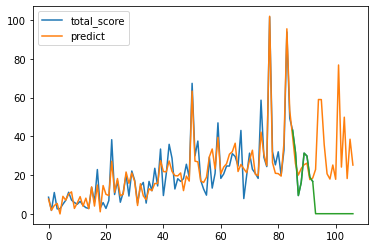

In [349]:
y_mlp.plot()
seinfeld[seinfeld.season_y > 5].total_score.plot()
plt.y_labels(seinfeld.titles)

In [ ]:
for i in scripts.title.tolist():
    if 
        return(pd.DataFrame(i))

In [ ]:
seinfeld_prepped.corr()

In [ ]:
grouped_scripts.Character.value_counts()/len(grouped_scripts.Character.sum())

In [357]:
str(scripts[scripts.SEID=='S01E00'][['Character','Dialogue']]).split('\n')

['    Character                                           Dialogue',
 '0       JERRY  Do you know what this is all about? Do you kno...',
 '1       JERRY  (pointing at Georges shirt) See, to me, that b...',
 '2      GEORGE                                   Are you through?',
 '3       JERRY             You do of course try on, when you buy?',
 '4      GEORGE  Yes, it was purple, I liked it, I dont actuall...',
 '..        ...                                                ...',
 '206     LAURA                     Yeah, yeah, hes a great guy...',
 '207     JERRY                                              Yeah.',
 '208     LAURA  Youd really like him, you know, I cant wait to...',
 '209     JERRY                                            Me too!',
 '210     JERRY  I swear, I have absolutely no idea what women ...',
 '',
 '[210 rows x 2 columns]']

In [383]:
scripts['line']=scripts.Character.str.strip() +': ' + scripts.Dialogue.str.strip()

In [385]:
scripts.line.str.replace(' ','_')

0        JERRY:_Do_you_know_what_this_is_all_about?_Do_...
1        JERRY:_(pointing_at_Georges_shirt)_See,_to_me,...
2                                 GEORGE:_Are_you_through?
3            JERRY:_You_do_of_course_try_on,_when_you_buy?
4        GEORGE:_Yes,_it_was_purple,_I_liked_it,_I_dont...
                               ...                        
54611    JERRY:_Grand_theft_auto_-_don't_steal_any_of_m...
54612            PRISONER_3:_You_suck_-_I'm_gonna_cut_you.
54613    JERRY:_Hey,_I_don't_come_down_to_where_you_wor...
54614    GUARD:_Alright,_Seinfeld,_that's_it._Let's_go....
54615    JERRY:_Alright,_hey,_you've_been_great!_See_yo...
Length: 53962, dtype: object

In [394]:
seinfeld['script'] = ''
for i in seinfeld.seid.tolist():
    for episode in scripts.SEID.tolist():
        seinfeld['script']=scripts[scripts.SEID==i].line.tolist()

ValueError: Length of values (210) does not match length of index (107)

In [398]:
seinfeld['script'] = scripts.groupby('SEID').line

ValueError: Length of values (174) does not match length of index (107)